In [35]:
def calculate_map(mask, gt):
  #draw contours on final image
    cnts, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(contours, cnts, -1, (0, 255, 0), 2)
    boxes = []
    for cnt in cnts:
        bb = cv2.boundingRect(cnt)
        boxes.append([bb[0], bb[1], bb[0]+bb[2], bb[1]+bb[3]])
    preds = [
        {
            # The boxes keyword should contain an [N,4] tensor,
            # where N is the number of detected boxes with boxes of the format
            # [xmin, ymin, xmax, ymax] in absolute image coordinates
            "boxes": Tensor(boxes),
            # The scores keyword should contain an [N,] tensor where
            # each element is confidence score between 0 and 1
            "scores": Tensor(np.ones(len(boxes))),
            # The labels keyword should contain an [N,] tensor
            # with integers of the predicted classes
            "labels": IntTensor(np.ones(len(boxes))),
            # The masks keyword should contain an [N,H,W] tensor,
            # where H and W are the image height and width, respectively,
            # with boolean masks. This is only required when iou_type is `segm`.
            "masks": BoolTensor([mask]),
        }
    ]
    gt = cv2.resize(gt, (contours.shape[1], contours.shape[0])).astype(np.uint8)
    cnts, hierarchy = cv2.findContours(gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cnt in cnts:
        bb = cv2.boundingRect(cnt)
        boxes.append([bb[0], bb[1], bb[0]+bb[2], bb[1]+bb[3]])
    target = [
    {
        "boxes": Tensor(boxes),
        "labels": IntTensor(np.ones(len(boxes))),
        "masks": BoolTensor([gt]),
    }
    ]

    metric = MeanAveragePrecision(iou_type="bbox")

    # Update metric with predictions and respective ground truth
    metric.update(preds, target)
    result = metric.compute()
    return  result["map"]


In [36]:
import csv
import os

import cv2
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils.metrics import  iou
from scipy.spatial import cKDTree

from dataManager import FolderDataManager
from maskPredictor import MaskPredictor

from utils.show import visualizer

def datagen(path, img_prefix, mask_prefix, weights, batch_size=1, num=10):
    """Data generator: takes video and weights path and produce a tuple: masks and source """
    data_mngr = FolderDataManager(path, img_prefix, mask_prefix)
    frame_generator = data_mngr.get_frames_gen(batch_size=batch_size,
                                               num=num)
    nn_model = MaskPredictor(weights)
    masks_generator = nn_model.get_mask_gt_generator(frame_generator, th=0.7)

    iou_summ = 0
    iou_min = 1
    iou_max = 0
    summ_map = 0


    for i, (mask, gray, source, gt) in tqdm(enumerate(masks_generator)):
        ## contours
        contours = source.copy()
        frame = source.copy()
        mask = cv2.resize(mask, (contours.shape[1], contours.shape[0])).astype(np.uint8)

        #draw contours on final image
        cnts, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(contours, cnts, -1, (0, 255, 0), 2)
        mask = cv2.resize(mask, (256, 256))
        gt = cv2.resize(cv2.cvtColor(gt, cv2.COLOR_RGB2GRAY), (256, 256))
        curr_iou = iou(mask, gt)
        curr_map = calculate_map(mask, gt)
        summ_map += curr_map
        iou_summ += curr_iou
        # print(i, curr_iou)
        if curr_iou < iou_min:
            iou_min = curr_iou
        if curr_iou > iou_max:
            iou_max = curr_iou


        data = {'orig': source,
                'mask': mask,
                'contours':  contours,
                'gt':gt
                }
        yield data
    print("Avg IoU", iou_summ/10, "Avg maP", summ_map/10, "Min IoU", iou_min,"Max IoU", iou_max)


10it [00:11,  1.11s/it]


Avg IoU 0.2604799843347887 Avg maP tensor(1.0801e-05) Min IoU 0.17348799889301172 Max IoU 0.5509048283973631


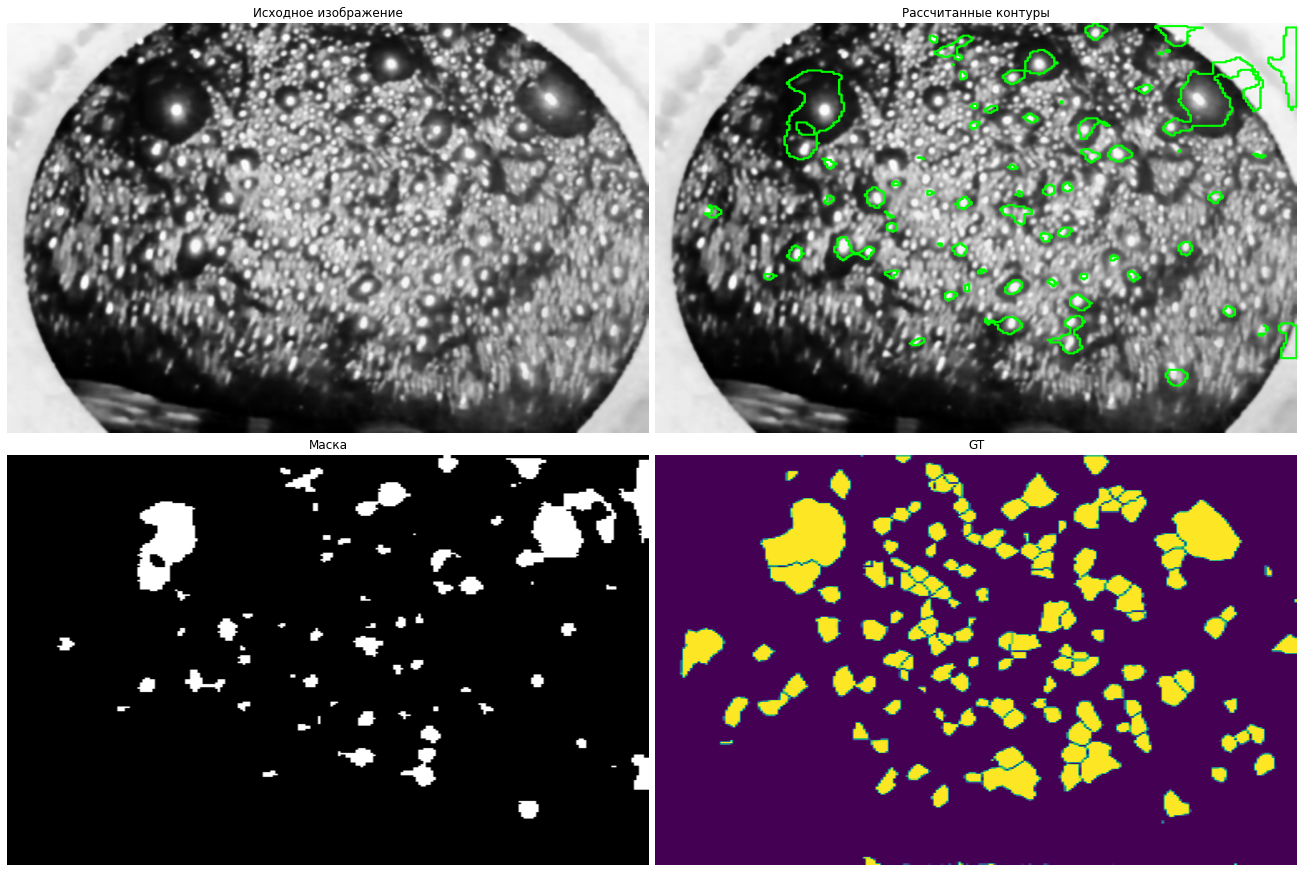

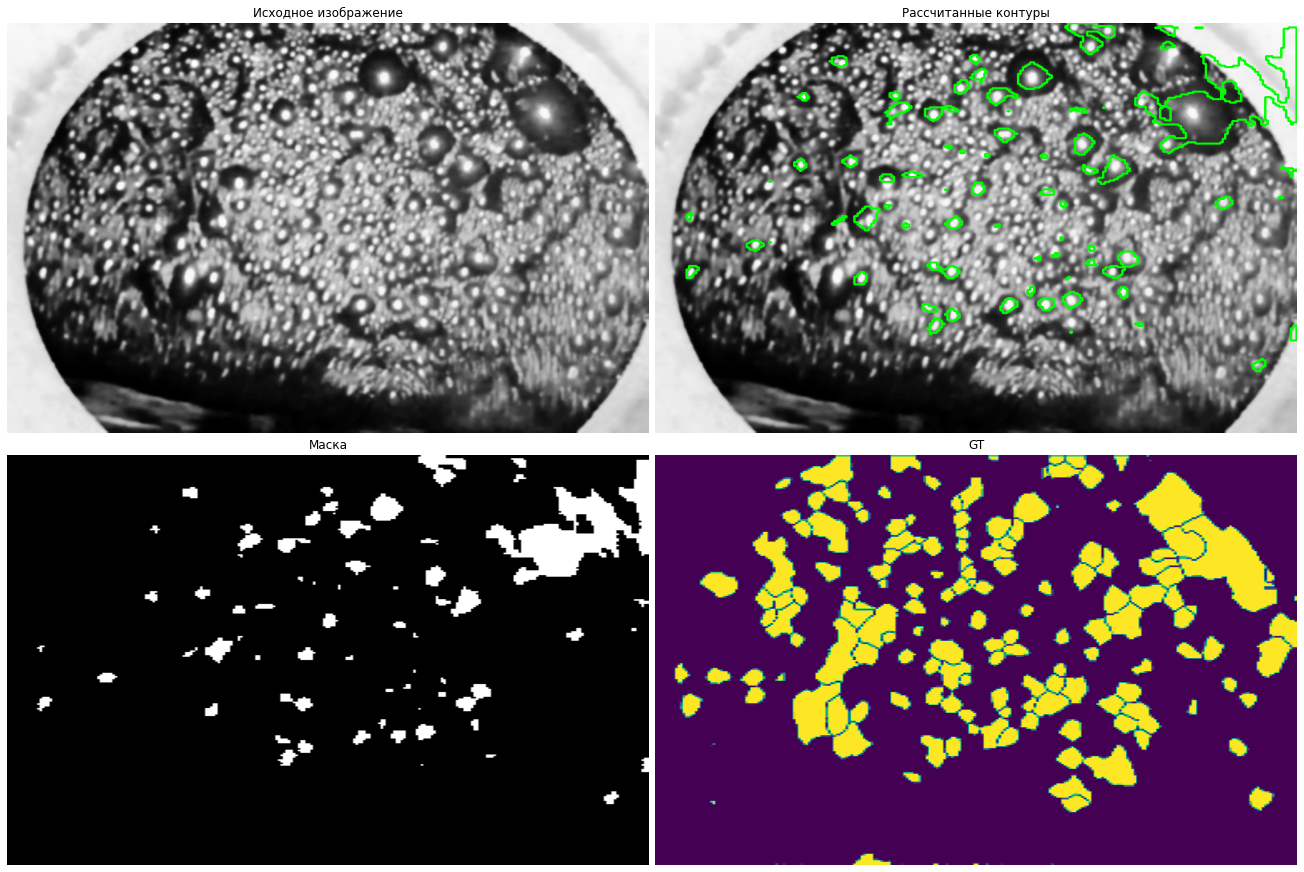

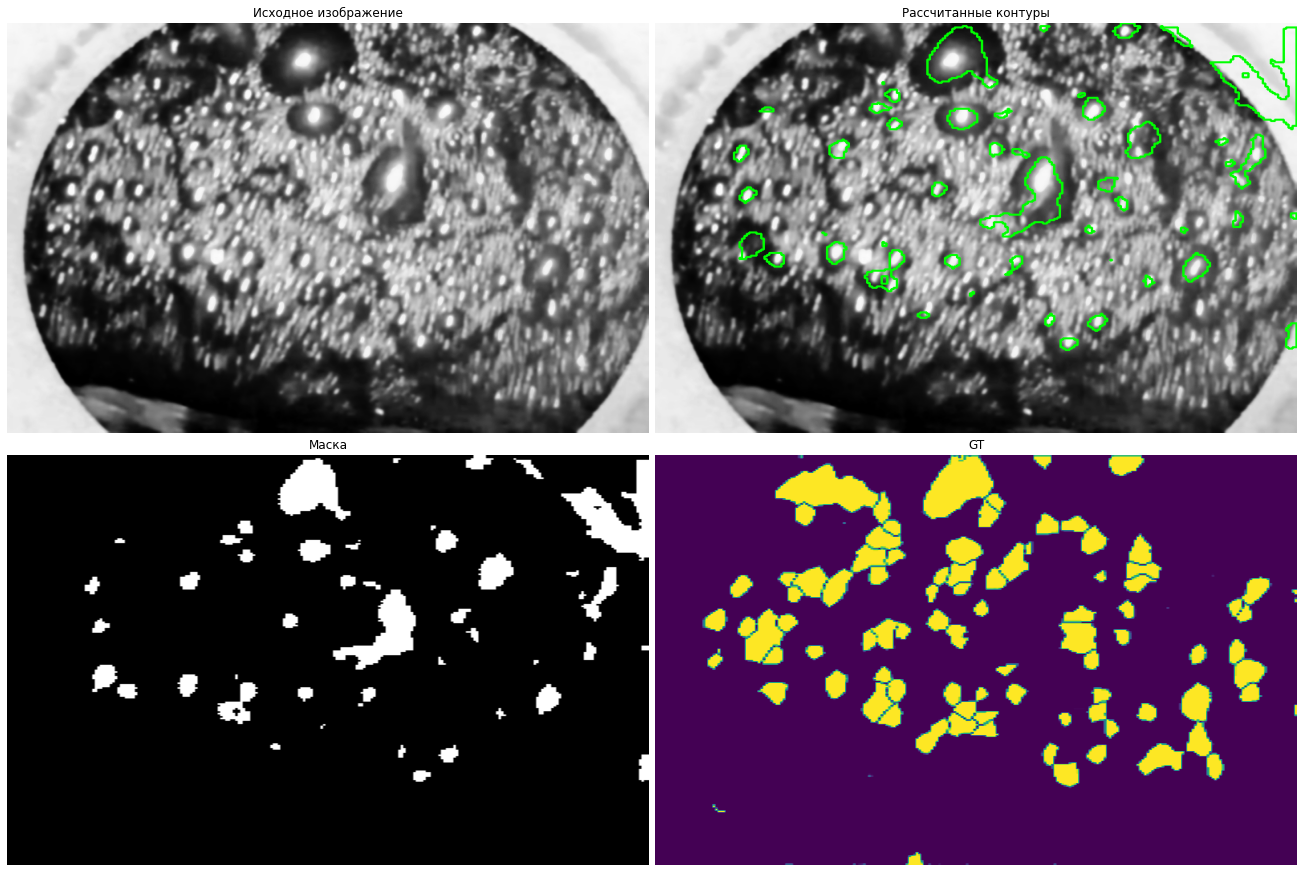

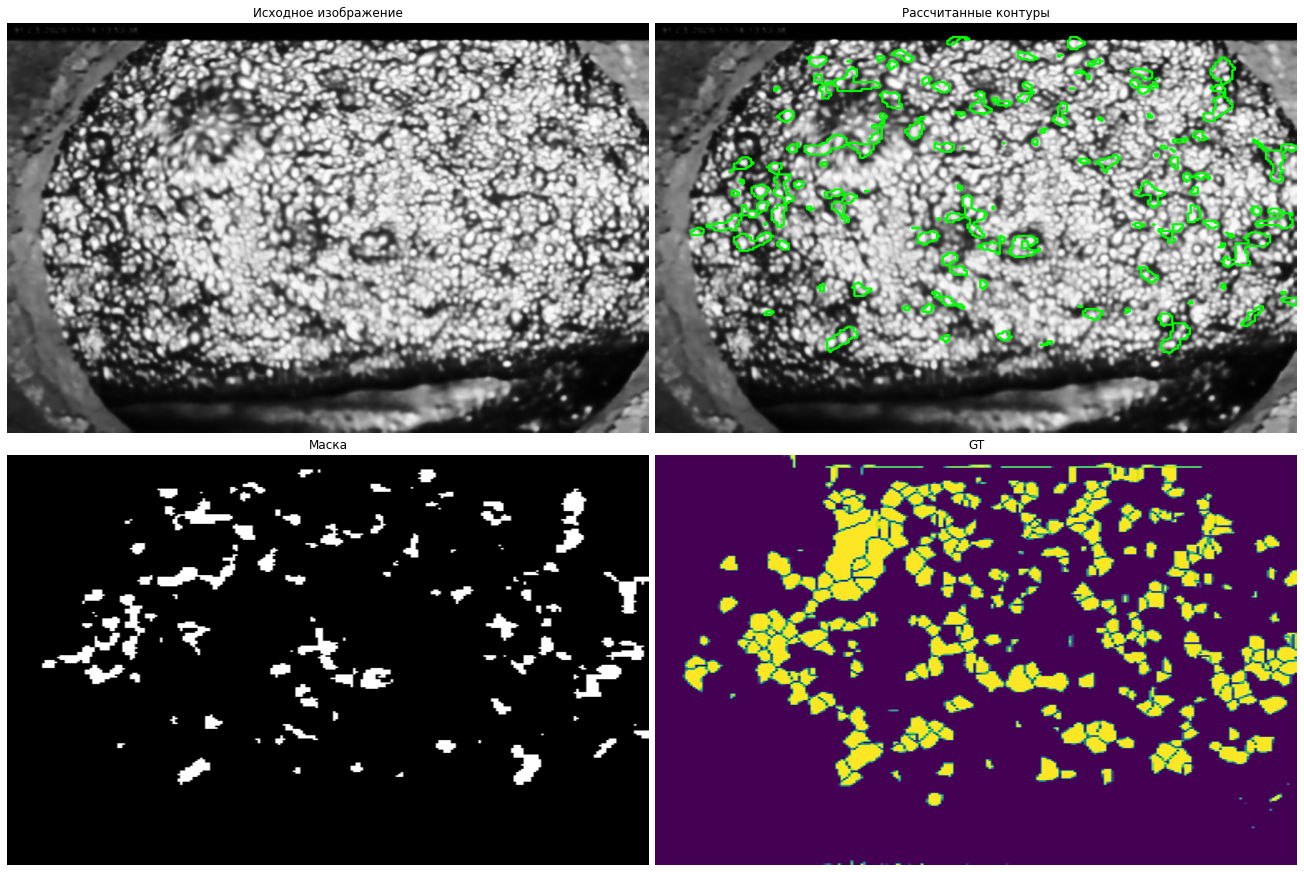

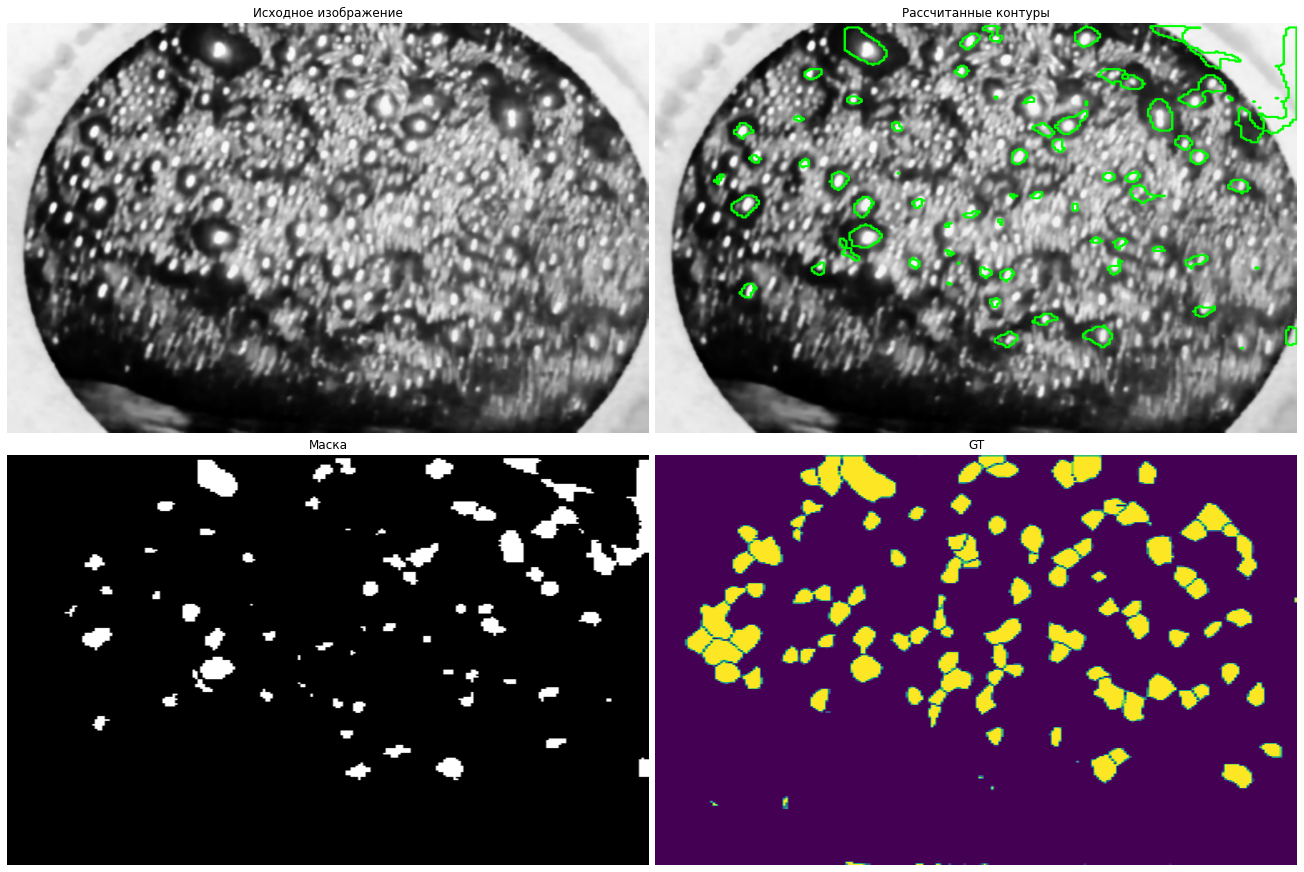

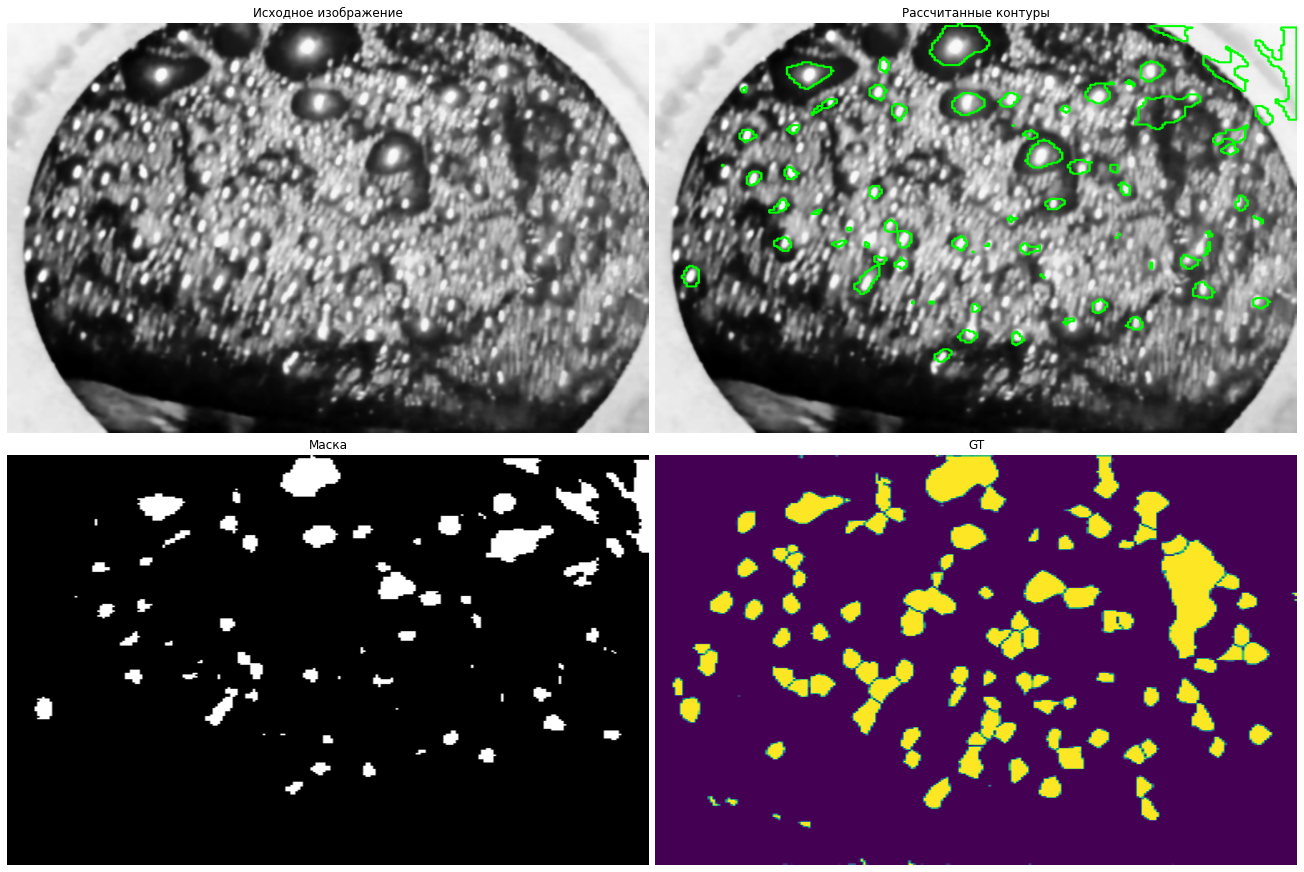

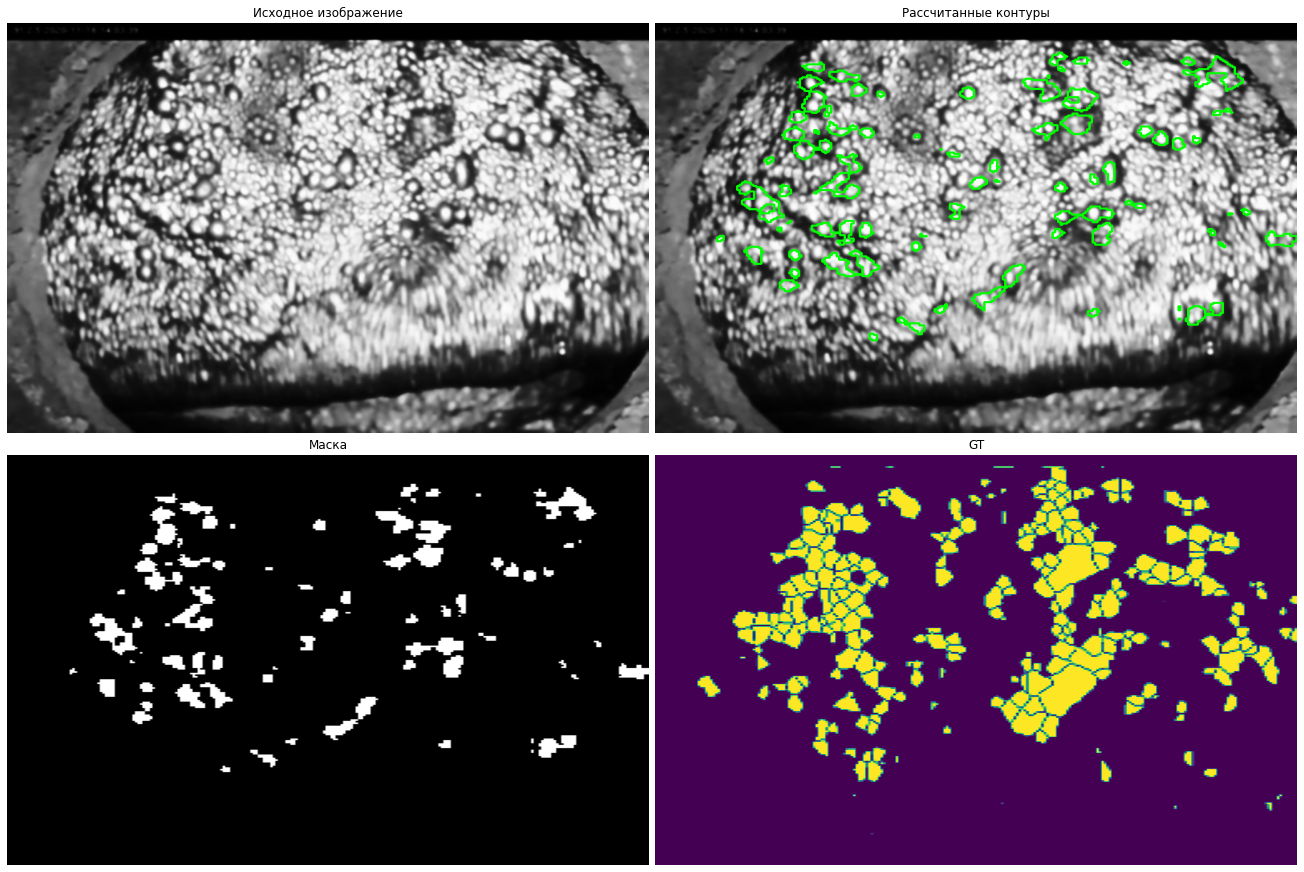

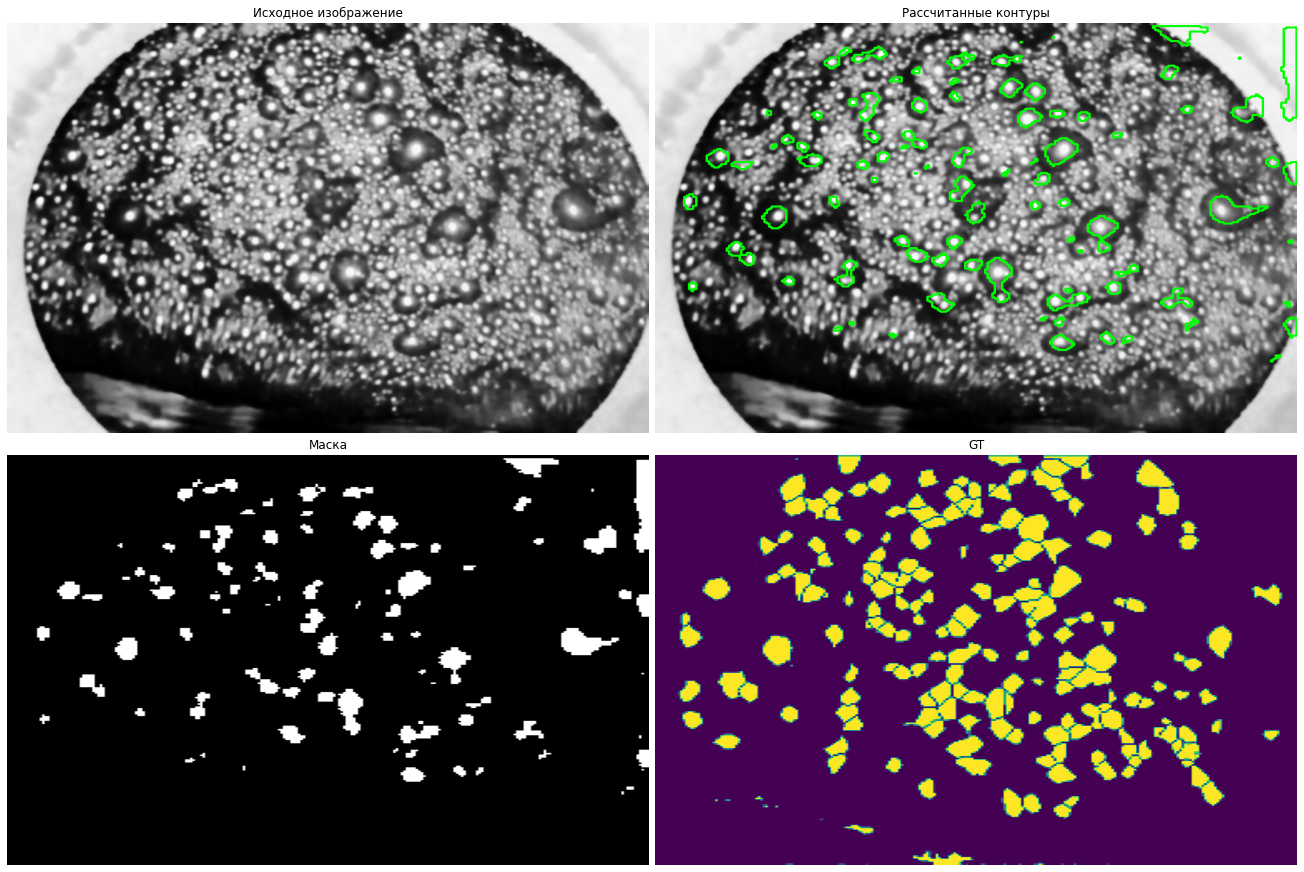

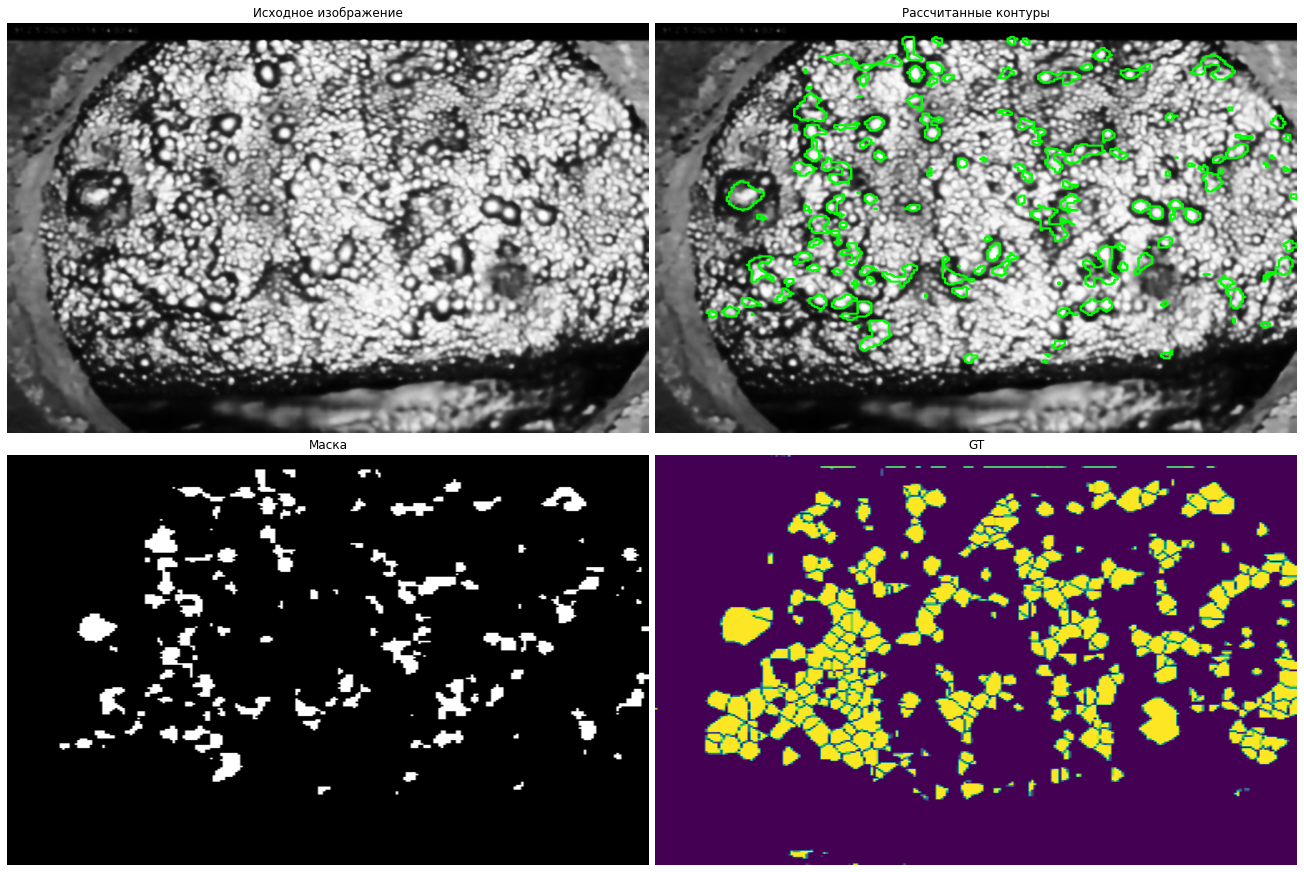

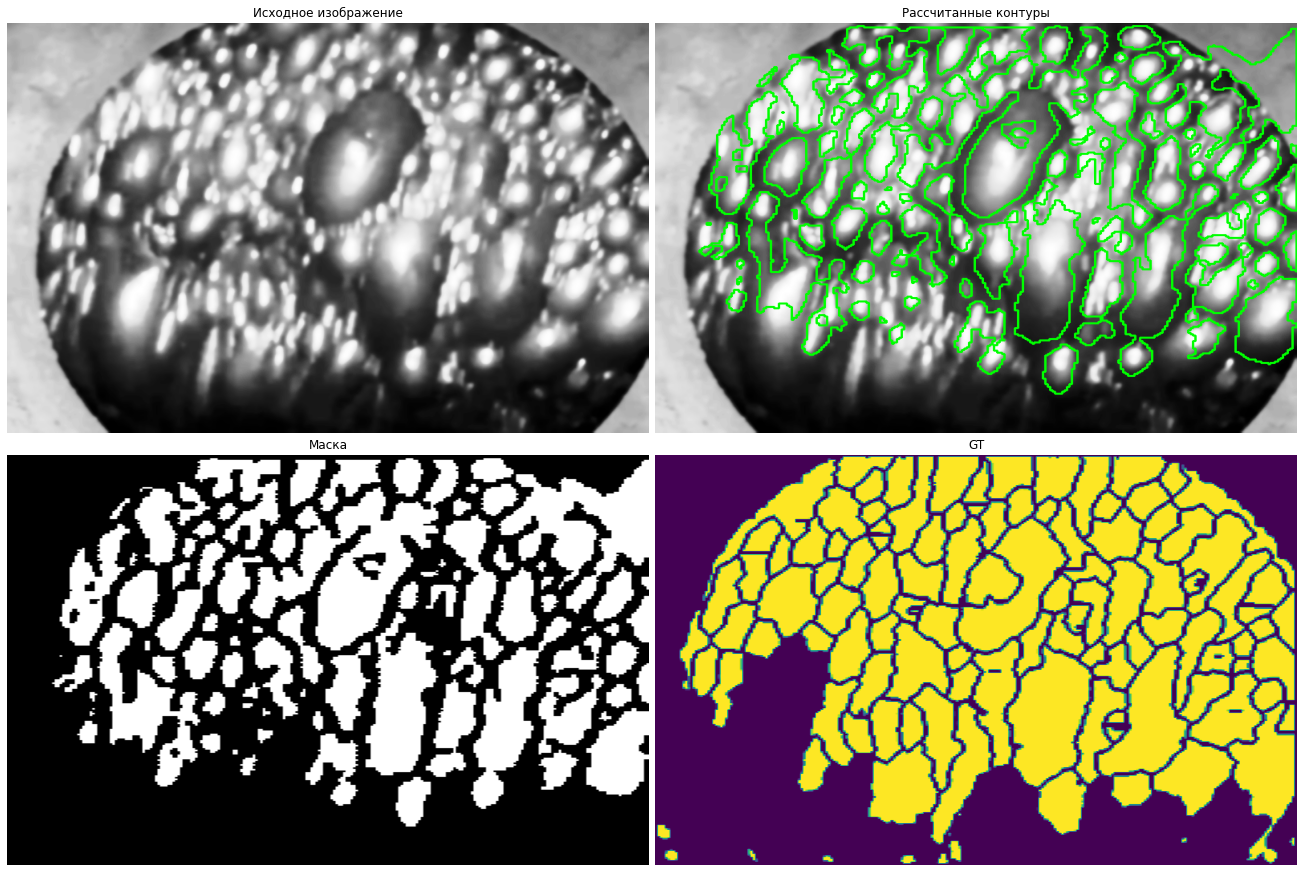

In [37]:
from  models.attunet import  *
# from models.transunet import *
from models.dstransunet import *
if not os.path.exists('./results'):
    os.makedirs('./results')

if not os.path.exists('./weights'):
    os.makedirs('./weights')

if not os.path.exists('../data'):
    os.makedirs('../data')

generator = datagen(path='data/test_dataset', img_prefix='image', mask_prefix='label', weights='weights/attunet_weights-3.pt', batch_size=1, num=10)
visualizer(generator)


Avg IoU 0.001745007626177713 Avg maP tensor(0.0037) Min IoU 0.00029479491955617846 Max IoU 0.0031166015732904152


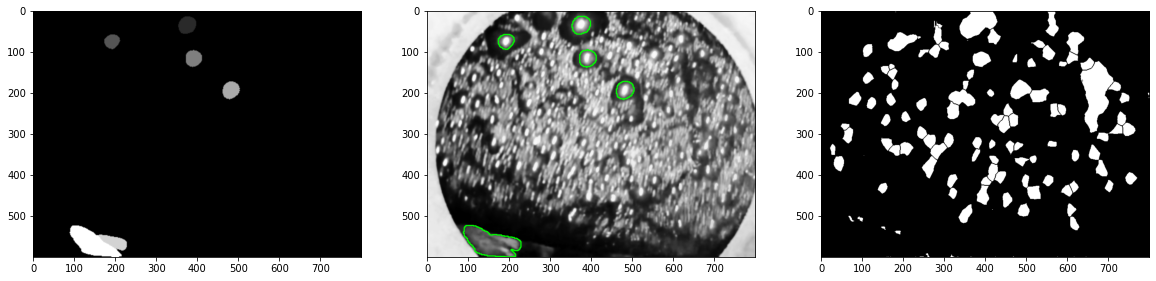

In [24]:
import os
from utils.show import show

from torch import Tensor, IntTensor, BoolTensor

from torchmetrics.detection.mean_ap import MeanAveragePrecision

mask_dir = '/Users/s70c3/Projects/NornilFroathOpticalFlow/data/test_dataset/'
mask_list = os.listdir(os.path.join(mask_dir, 'label'))
iou_summ = 0
iou_min = 1
iou_max = 0
summ_map = 0
for name in mask_list:
    gt = cv2.imread(os.path.join(mask_dir, 'label', name))
    contours = cv2.imread(os.path.join(mask_dir, 'image', name))
    cell_pose = cv2.imread(os.path.join(mask_dir, 'cell_pose', name))
    curr_iou = iou(cv2.resize(cv2.cvtColor(cell_pose, cv2.COLOR_RGB2GRAY), (256, 256)),
                                  cv2.resize(cv2.cvtColor(gt, cv2.COLOR_RGB2GRAY), (256, 256)))

    mask = cv2.cvtColor(cv2.resize(cell_pose, (contours.shape[1], contours.shape[0])).astype(np.uint8),             cv2.COLOR_RGB2GRAY)

    curr_map = calculate_map(mask, gt)
    iou_summ += curr_iou
    summ_map += curr_map
    if curr_iou < iou_min:
        iou_min = curr_iou
    if curr_iou > iou_max:
        iou_max = curr_iou
print("Avg IoU", iou_summ/10, "Avg maP", summ_map/10, "Min IoU", iou_min,"Max IoU", iou_max)
show(mask, contours, gt)